In [1]:
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

要先建立輸入到模型的資料
- 若是要分類是否是熱點，應該要以一個區域的grid為單位
- 所以建立得grid亦包含該地區的所有特徵資料，以比例顯示

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Arial Unicode Ms']
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

from utils_model import  model_preprocess
from utils import read_data, read_taiwan_specific

## obtain hotspot's county
這段使用將grid依照geometry找出個別在哪個城市

In [4]:
taiwan, grid_filter = read_taiwan_specific(read_grid=True)

computeddata = 'ComputedDataV2'
# all_featuresV2 為將離群替換為中位數
all_features_df = pd.read_csv(f"../{computeddata}/ForModel/all_featuresV1.csv")

# 移除高共線
cols = all_features_df.columns[all_features_df.columns.str.contains('事故位置大類別名稱')]
cols2 = all_features_df.columns[all_features_df.columns.str.contains('號誌動作')]
cols3 = all_features_df.columns[all_features_df.columns.str.contains('original_speed')]
all_features_df.drop(columns=cols, inplace=True)
all_features_df.drop(columns=cols2, inplace=True)
all_features_df.drop(columns=cols3, inplace=True)

In [5]:
X_train, X_test, y_train, y_test, X_resampled_test, y_resampled_test, le = model_preprocess(grid_filter, all_features_df)

/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [6]:
import joblib

# load model
lr = joblib.load(f'../{computeddata}/ModelPerformance/lr_modelV1.pkl')

proba_test_lr = lr.predict_proba(X_resampled_test)

In [9]:
def get_importance_for_youbike(model, df, specific_col=None):
    # The importance doesn't consider interaction terms
    if model.__class__.__name__ == 'LogisticRegression':
        importances = model.coef_[0]
    else:
        importances = model.feature_importances_

    feature_names = df.columns

    if specific_col:
        sel_idx = [i for i, name in enumerate(feature_names) if specific_col in name]
        indices = np.argsort(importances[sel_idx])[::-1]
        indices = [sel_idx[i] for i in indices] # 對應回原始 index
    else:
        indices = np.argsort(importances)[::-1]

    importance_ungrouped = {}
    for i in indices:
        importance_ungrouped[feature_names[i]] = importances[i]

    return importance_ungrouped

importance_lr = get_importance_for_youbike(lr, X_train)

In [12]:
df_ts_youbike = pd.DataFrame()
for i in importance_lr:
    if ('youbike' in i) and 'county' not in i:
        # print(i, np.exp(importance_lr[i]))
        df_ts_youbike = pd.concat([df_ts_youbike, pd.DataFrame({
            'feature': [i], 'importance': [importance_lr[i]], 'exp_importance': [np.exp(importance_lr[i])]
            })], axis=0)
        
df_ts_youbike['feature'] = df_ts_youbike['feature'].str.replace(' x youbike_100m_count_mean', '')
df_ts_youbike['feature'] = df_ts_youbike['feature'].str.replace('youbike_100m_count_mean x ', '')
df_ts_youbike.sort_values('exp_importance', ascending=True, inplace=True)

In [13]:
from config import col_translation

df_ts_youbike['feature_en'] = df_ts_youbike['feature'].map(col_translation)

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_4407/1378829561.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Greens")


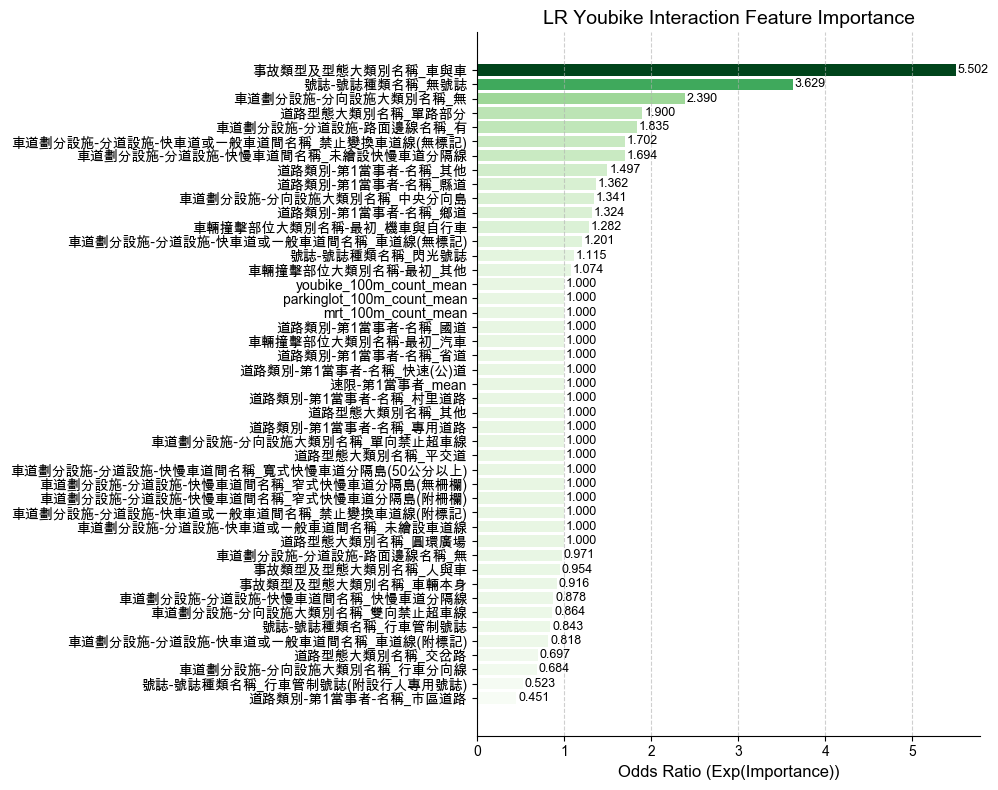

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

df_sorted = df_ts_youbike.sort_values('exp_importance', ascending=True)

plt.figure(figsize=(10, 8))

norm = mcolors.Normalize(vmin=df_sorted['exp_importance'].min(),
                         vmax=df_sorted['exp_importance'].max())
cmap = cm.get_cmap("Greens")
colors = [cmap(norm(val)) for val in df_sorted['exp_importance']]

bars = plt.barh(df_sorted['feature'], df_sorted['exp_importance'], color=colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"{width:.3f}", va='center', fontsize=9)
plt.xlabel('Odds Ratio (Exp(Importance))', fontsize=12)
plt.title('LR Youbike Interaction Feature Importance', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
